### Importations

In [4]:
import os
import numpy as np
import xarray as xr
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
from typing import List, Tuple, TypeAlias
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
plt.rc('text', usetex=True)
plt.rcParams.update({
    'text.usetex': True,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

data disponible at
https://github.com/glwagner/SingleColumnModelCalibration.jl?tab=readme-ov-file

# Run forward *Tunax* LES simulations

In [1]:
from tunax import Obs, SingleColumnModel
from tunax.closures import KepsParameters
import jax.numpy as jnp
from jax import vmap
import equinox as eqx
import numpy as np
import os

timeframe_list = [6, 12, 24, 48, 72]
space_step_list = [1, 2, 4]
forcing_list = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]

var_names = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

dims = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    return omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) - omega_m

In [2]:
for space_step in space_step_list[:1]:
    for timeframe in timeframe_list[:1]:
        for forcing in forcing_list[:1]:
            print(f'{space_step}m', f'{timeframe}h', forcing)
            filename = os.path.join(
                'k-epsilon_Wagner_LES', 'Wagner_LES',f'{timeframe}_hour_suite',
                f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2')
            output_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
            obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)

            # case corrections
            obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
            obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, (0., -obs.metadatas['b_str']))
            obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

            # passive tracer forcing
            omega_p = 1/obs.metadatas['pt_timescale']
            lambda_c = obs.metadatas['pt_width']
            zc = obs.metadatas['pt_depth']
            l_z = obs.trajectory.grid.hbot
            def wrapped_forcing(z):
                return forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
            # maped_fun = vmap(forcing_passive_tracer, in_axes=(0, None, None, None, None), out_axes=0)
            # pt_forcing = maped_fun(obs.trajectory.grid.zr, omega_p, lambda_c, -zc, l_z)
            obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing, obs, wrapped_forcing)
            obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

            # sun forcing
            if 'sunny_flux' in obs.metadatas.keys():
                sunny_flux = obs.metadatas['sunny_flux']
                if isinstance(sunny_flux, float):
                    pass

            traj_wagner = obs.trajectory
            time_frame = float(traj_wagner.time[-1]/3600)
            dt = 10.
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            init_state = traj_wagner.extract_state(0)
            model = SingleColumnModel(time_frame, dt, out_dt, init_state, obs.case, 'k-epsilon', output_path)

            keps_params = KepsParameters()

            model.compute_trajectory_with(keps_params)

1m 6h free_convection


/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


In [10]:
obs.case

Case(
  rho0=1024.0,
  grav=9.80665,
  cp=3985.0,
  eos_tracers='b',
  alpha=0.0002,
  beta=0.0008,
  t_rho_ref=0.0,
  s_rho_ref=35.0,
  do_pt=True,
  vkarmn=0.384,
  fcor=0.0001,
  ustr_sfc=-0.0,
  ustr_btm=0.0,
  vstr_sfc=0.0,
  vstr_btm=0.0,
  t_forcing=None,
  s_forcing=None,
  b_forcing=(0.0, -9.6e-07),
  pt_forcing=f32[256](numpy),
  t_forcing_type=None,
  s_forcing_type=None,
  b_forcing_type='borders',
  pt_forcing_type='constant'
)

# Huge plots of Wagner

In [19]:

def plot(timeframe, space_step):
    sp: subplot_2D_type = plt.subplots(3, 6, sharey=True, figsize=(16, 12))
    fig, [axs_b, axs_uv, axs_pt] = sp

    for i_forcing in range(len(forcing_list)):
        forcing = forcing_list[i_forcing]
        wagner_path = os.path.join('k-epsilon_Wagner_LES', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
        filename_yaml = os.path.join('k-epsilon_Wagner_LES', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')
        wagner_obs: Obs = Obs.from_files(wagner_path, filename_yaml, var_names, 'b', True)
        wagner_traj = wagner_obs.trajectory
        tunax_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        i = -1
        axs_b[i_forcing].plot(wagner_traj.b[i, :], wagner_traj.grid.zr, 'r')
        axs_b[i_forcing].plot(tunax_ds.b[i, :], wagner_traj.grid.zr, 'g')
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_traj.u[-1, :], wagner_traj.grid.zr, 'r')
            axs_uv[i_forcing].plot(wagner_traj.v[-1, :], wagner_traj.grid.zr, 'r--')
            axs_uv[i_forcing].plot(tunax_ds.u[-1, :], wagner_traj.grid.zr, 'g')
            axs_uv[i_forcing].plot(tunax_ds.v[-1, :], wagner_traj.grid.zr, 'g--')
        axs_pt[i_forcing].plot(wagner_traj.pt[0, :], wagner_traj.grid.zr, 'r')
        axs_pt[i_forcing].plot(wagner_traj.pt[-1, :], wagner_traj.grid.zr, 'r')
        axs_pt[i_forcing].plot(tunax_ds.pt[0, :], wagner_traj.grid.zr, 'g')
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].set_title(f'time = {timeframe}h')
    axs_uv[0].legend(loc='center')
    axs_uv[0].axis('off')
    axs_b[0].set_ylim(-200, 2)

In [ ]:
from jax import tree_util

arr = jnp.zeros(10)
ar = tree_util.tree_flatten(arr)

ar+arrs

TypeError: unsupported operand type(s) for +: 'tuple' and 'ArrayImpl'

AttributeError: 'Dataset' object has no attribute 'b'

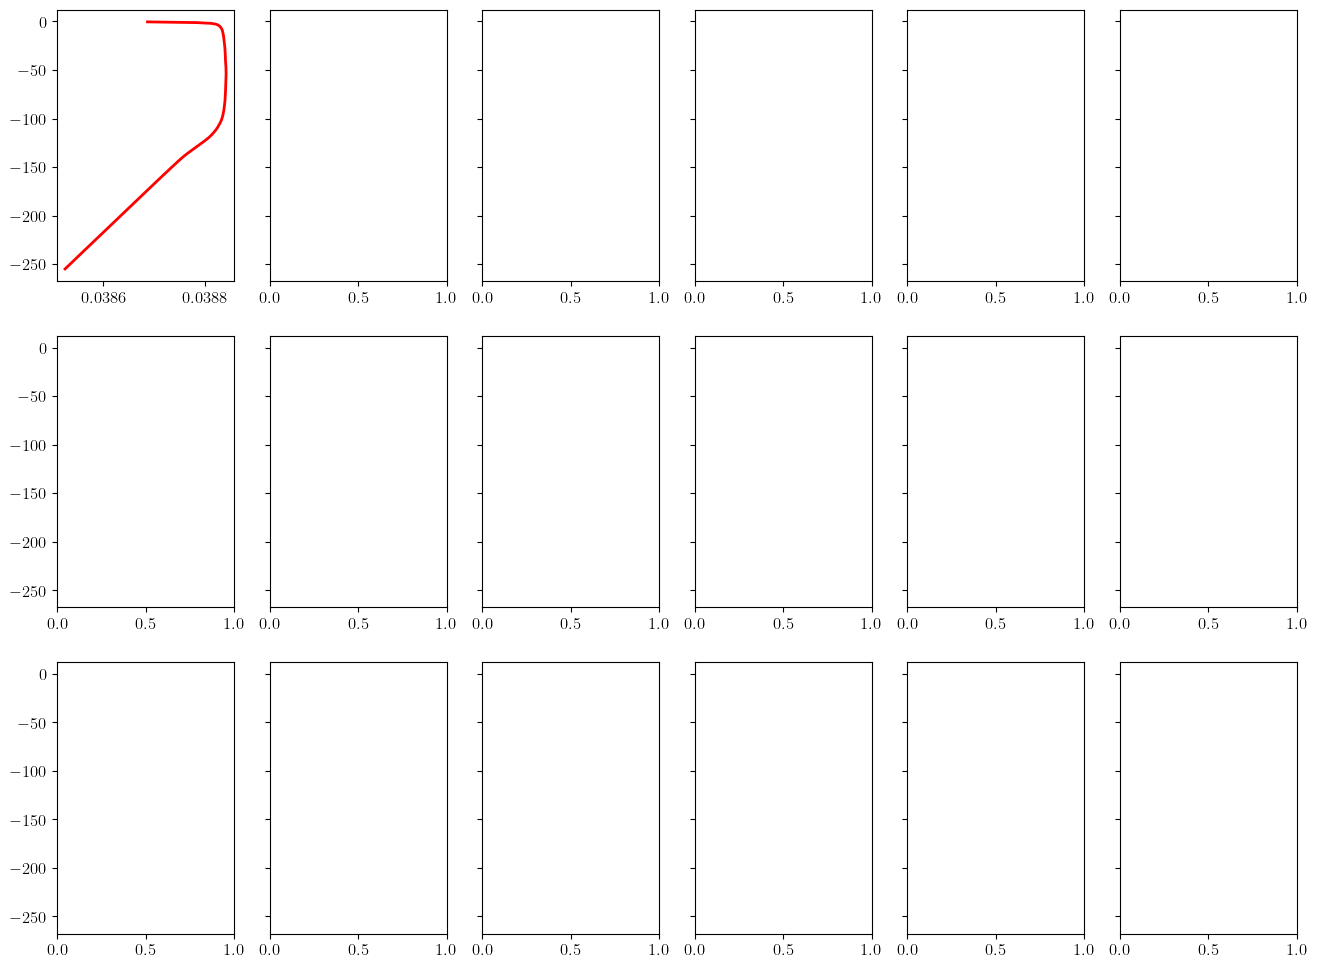

In [ ]:
plot(12, 1)


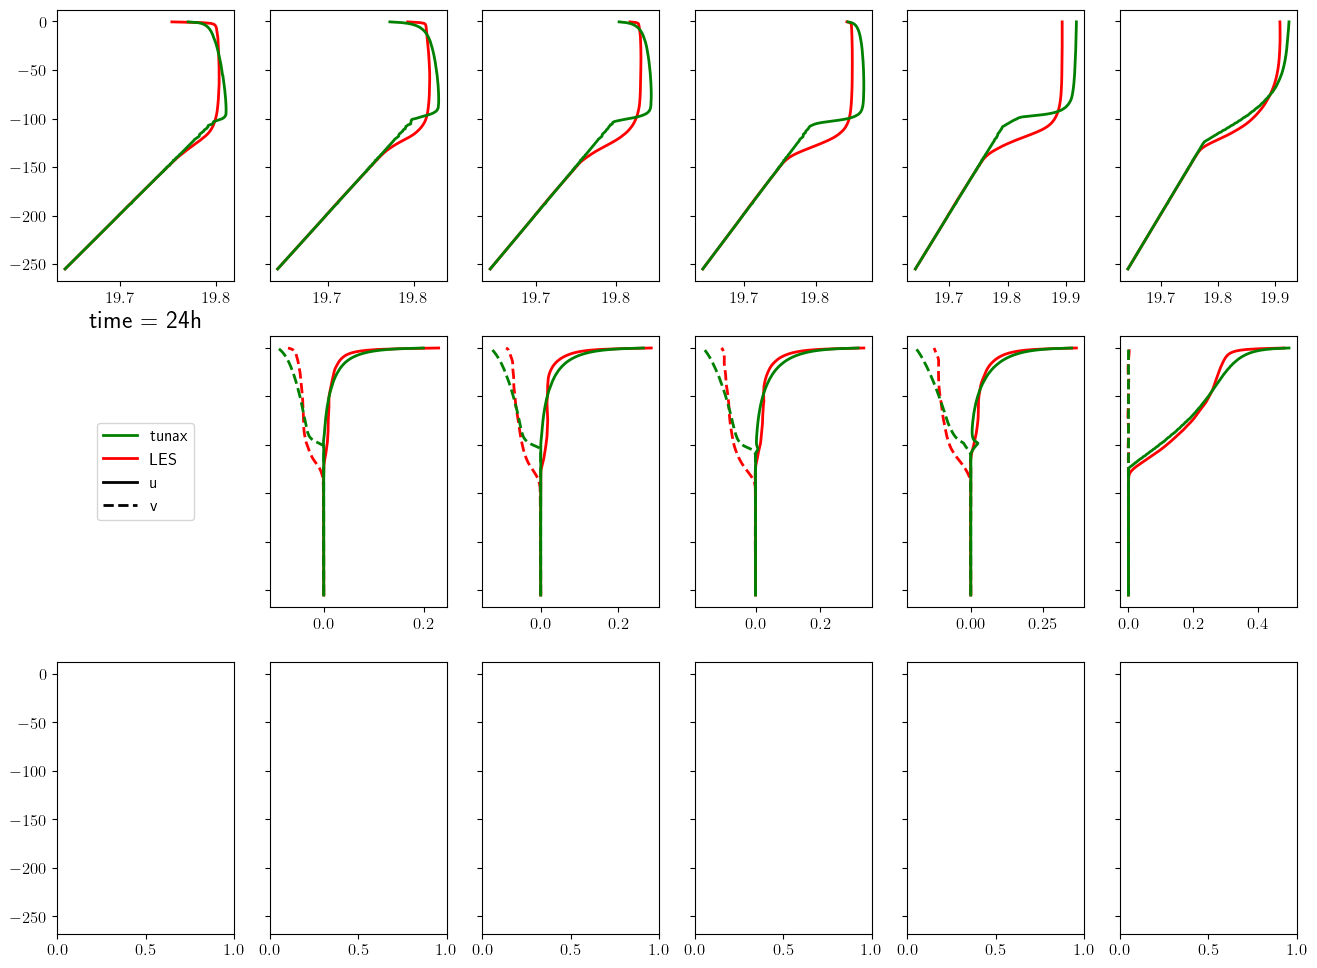

In [ ]:
plot(24, 1)


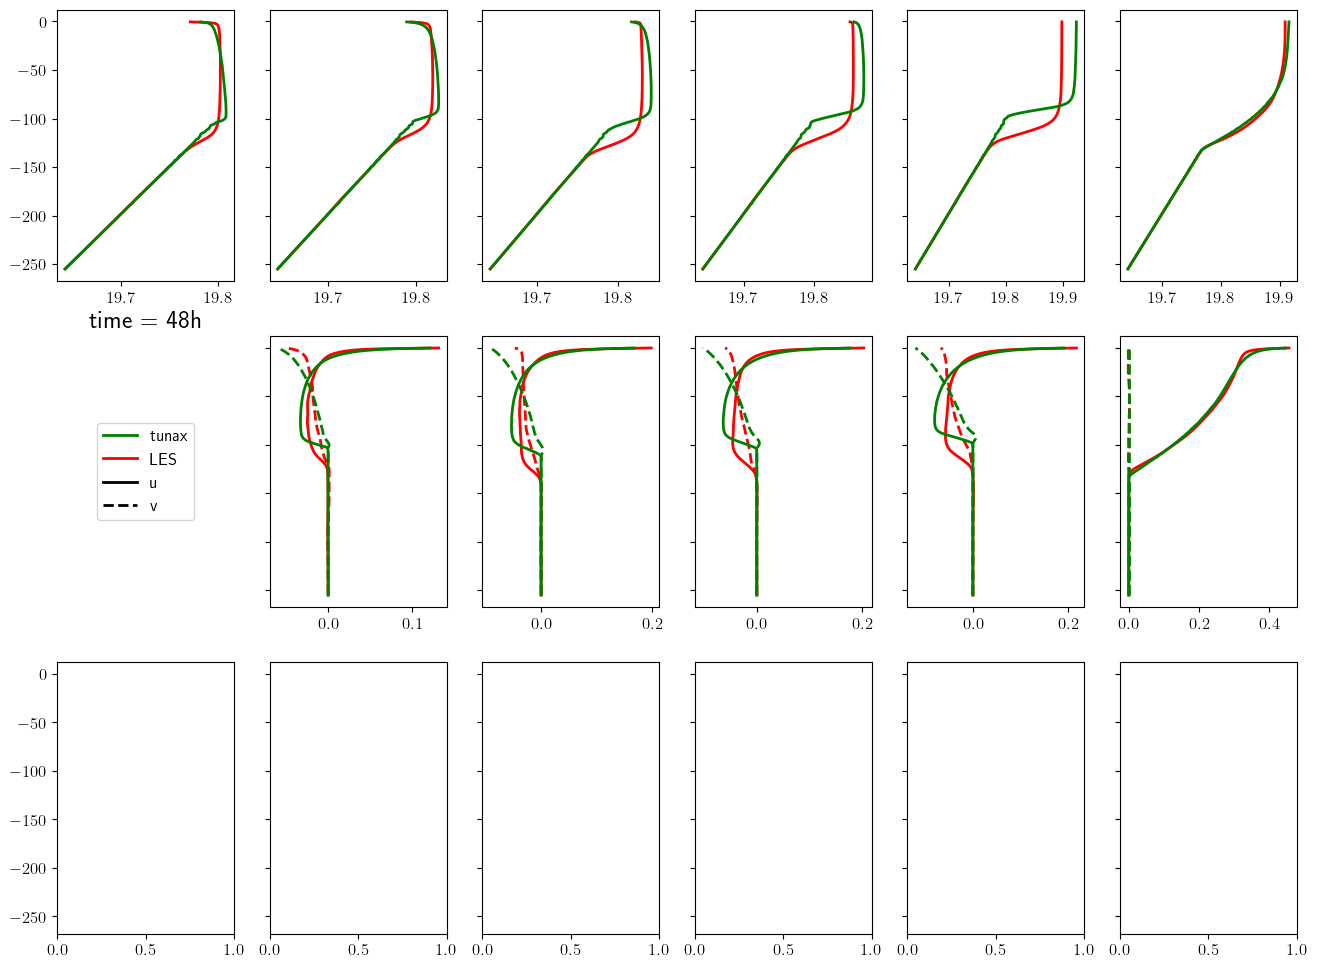

In [ ]:
plot(48, 1)


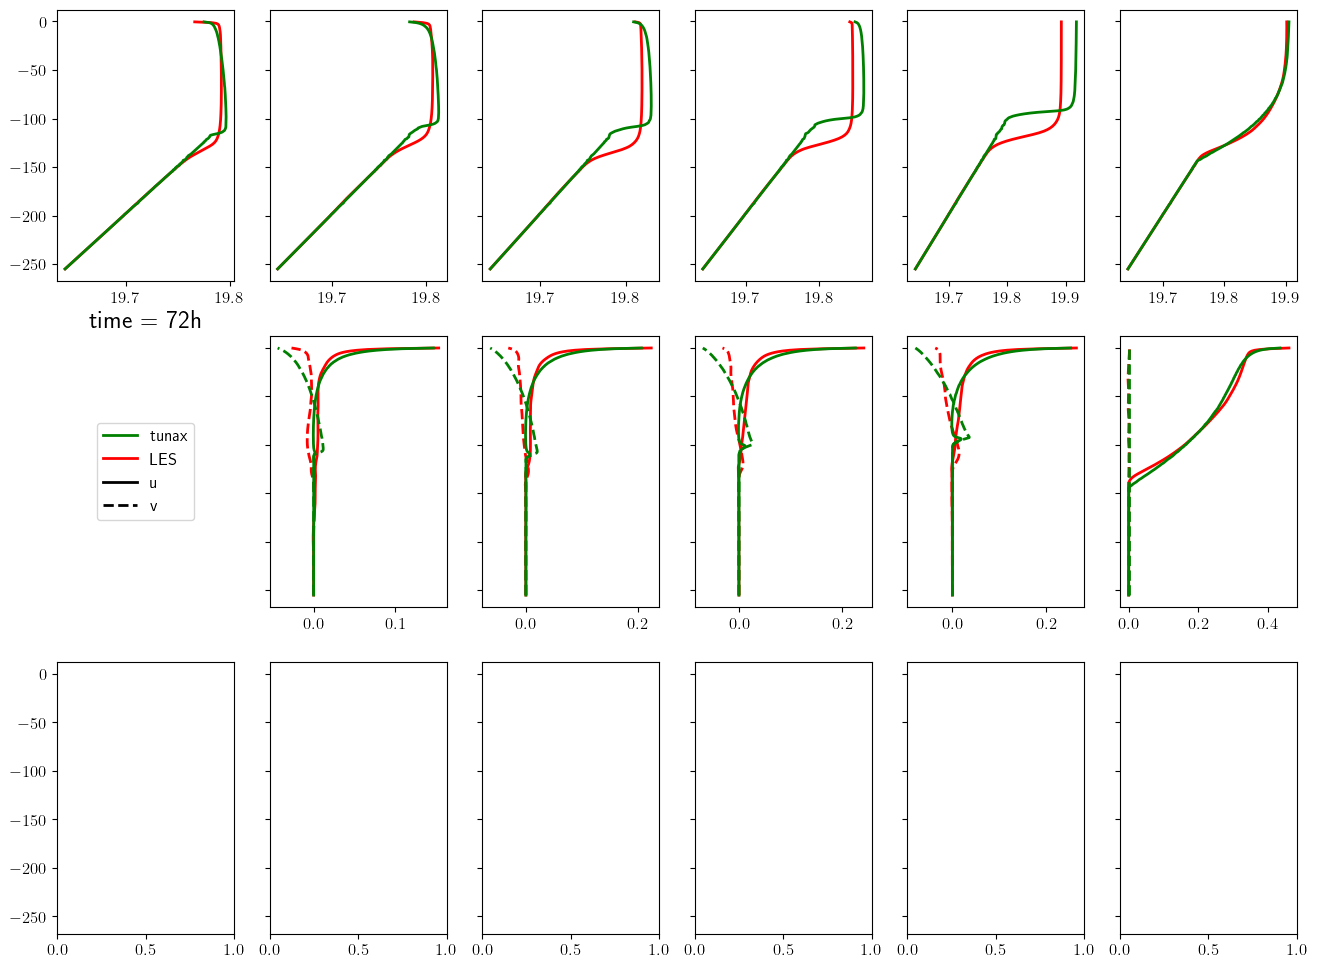

In [ ]:
plot(72, 1)
